### Imports

In [1]:
import matplotlib.pyplot as plt
import os
import sys
import torch
import torch.nn as nn
import torch.optim as optim

sys.path.append(os.path.abspath('../'))

from data import get_train_dataloader, get_test_dataloader
from mri import MRI
from nn import NeuralNet, GaussianMapping, PosEncMapping
from utils import get_device


%load_ext autoreload
%autoreload 2

In [2]:
# Load the MRI data from the file
file_path = '../../../hcp1200/996782/T1w_acpc_dc_restore_brain_downsample_factor_8.nii.gz'
mri = MRI.from_nii_file(file_path)

15:06:24 | Reading data from ../../../hcp1200/996782/T1w_acpc_dc_restore_brain_downsample_factor_8.nii.gz


15:06:25 | Displaying relevant brain slices


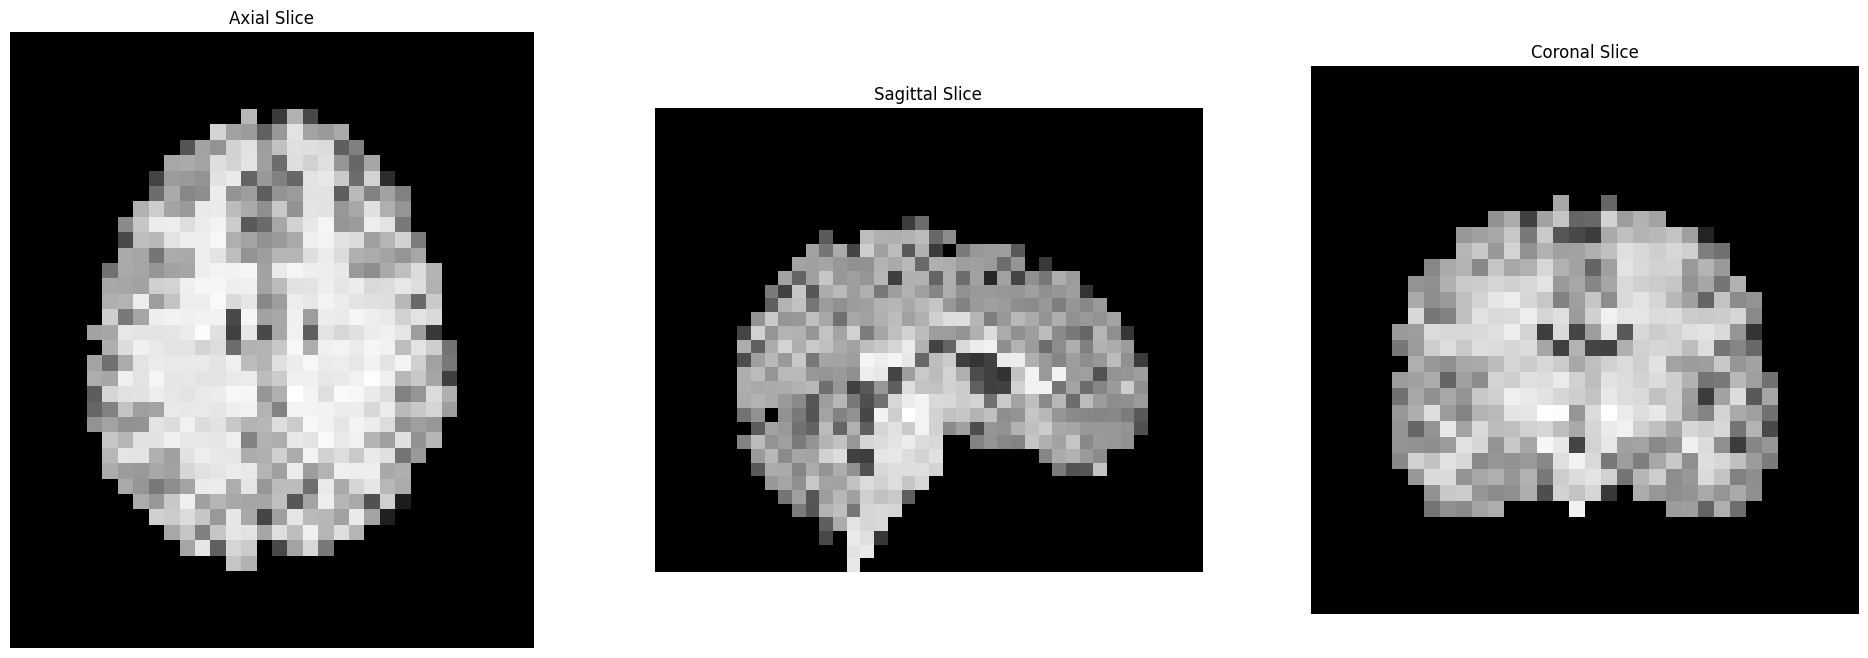

In [3]:
mri.display_relevant_brain_slices()

In [4]:
print(f"Voxel grid size: {mri.data.shape}")
print(f"Total number of points in MRI: {mri.data.flatten().shape[0]}")

Voxel grid size: (34, 40, 34)
Total number of points in MRI: 46240


In [5]:
device = get_device()
dataloader = get_train_dataloader(mri, batch_size=2048, device=device)

15:06:26 | Create voxel grid from MRI
15:06:26 | Creating voxel grid of shape (34, 40, 34)
15:06:26 | Get intensity values from MRI
15:06:26 | Creating the dataloader


------------------------------------------------------------
NVIDIA GeForce RTX 3050 Ti Laptop GPU
Memory Usage:
	Allocated: 0.0 GB
	Reserved:  0.0 GB
------------------------------------------------------------


### Training

In [6]:
# Initialize network
encoding = 'pos_enc'
if encoding == 'pos_enc':
    input_size = 96 #192 + 96
    fourier_mapping = PosEncMapping(num_frequencies=input_size//6, scale=1000)
else:
    input_size = 256
    fourier_mapping = GaussianMapping(num_frequencies=input_size//2, scale=10, device=device)

net = NeuralNet(input_size=input_size).to(device)

# Optimizer
optimizer = optim.Adam(net.parameters(), lr=1e-4)  # Adjust learning rate as needed

# Loss function
mse_loss = nn.MSELoss()

In [7]:
# Number of epochs - one epoch means the model has seen all the data once
num_epochs = 10  # Adjust as needed

for epoch in range(num_epochs):
    running_loss = 0.0
    for i, data in enumerate(dataloader):
        # Get the input features and target labels, and put them on the device
        coords, gt_intensity_values = data
        coords, gt_intensity_values = coords.to(device), gt_intensity_values.to(device)
        coords = fourier_mapping.map(coords)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass: compute predicted outputs by passing inputs to the model
        pred_intensity_values = net(coords)

        # Compute loss
        loss = mse_loss(pred_intensity_values.squeeze(), gt_intensity_values)

        # Backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()

        # Perform a single optimization step (parameter update)
        optimizer.step()

        # Print statistics
        running_loss += loss.item()

    print(f'[{epoch + 1}] loss: {running_loss / 100:.3f}')
    running_loss = 0.0

print('Finished Training')

[1] loss: 20421.661
[2] loss: 20157.081
[3] loss: 19967.830
[4] loss: 19870.412
[5] loss: 19836.984
[6] loss: 19750.072
[7] loss: 19769.905
[8] loss: 19704.496
[9] loss: 19668.098
[10] loss: 19595.569
Finished Training


In [8]:
voxel_size = (68, 80, 68)
voxel_loader = get_test_dataloader(mri, voxel_size, 2048, device)

# Set the network to evaluation mode
net.eval()

# Store predictions for each batch
batch_predictions = []

# Disable gradient calculations
with torch.no_grad():
    for batch in voxel_loader:
        # Move batch to device
        coords = batch.to(device)
        coords = fourier_mapping.map(coords)

        # Predict intensity values for the batch
        batch_pred = net(coords)

        # Move predictions to CPU and store
        batch_predictions.append(batch_pred.cpu())

# Concatenate all batch predictions
all_predictions = torch.cat(batch_predictions, dim=0)

# Convert to numpy array
predicted_intensities_np = all_predictions.squeeze().numpy()

# Reshape the array to the desired MRI dimensions
x_dim, y_dim, z_dim = voxel_size
predicted_mri = predicted_intensities_np.reshape((x_dim, y_dim, z_dim))

pred_mri = MRI.from_data_and_voxel_size(predicted_mri, (x_dim, y_dim, z_dim))

15:06:46 | Creating voxel grid of shape (68, 80, 68)


15:06:52 | Displaying relevant brain slices


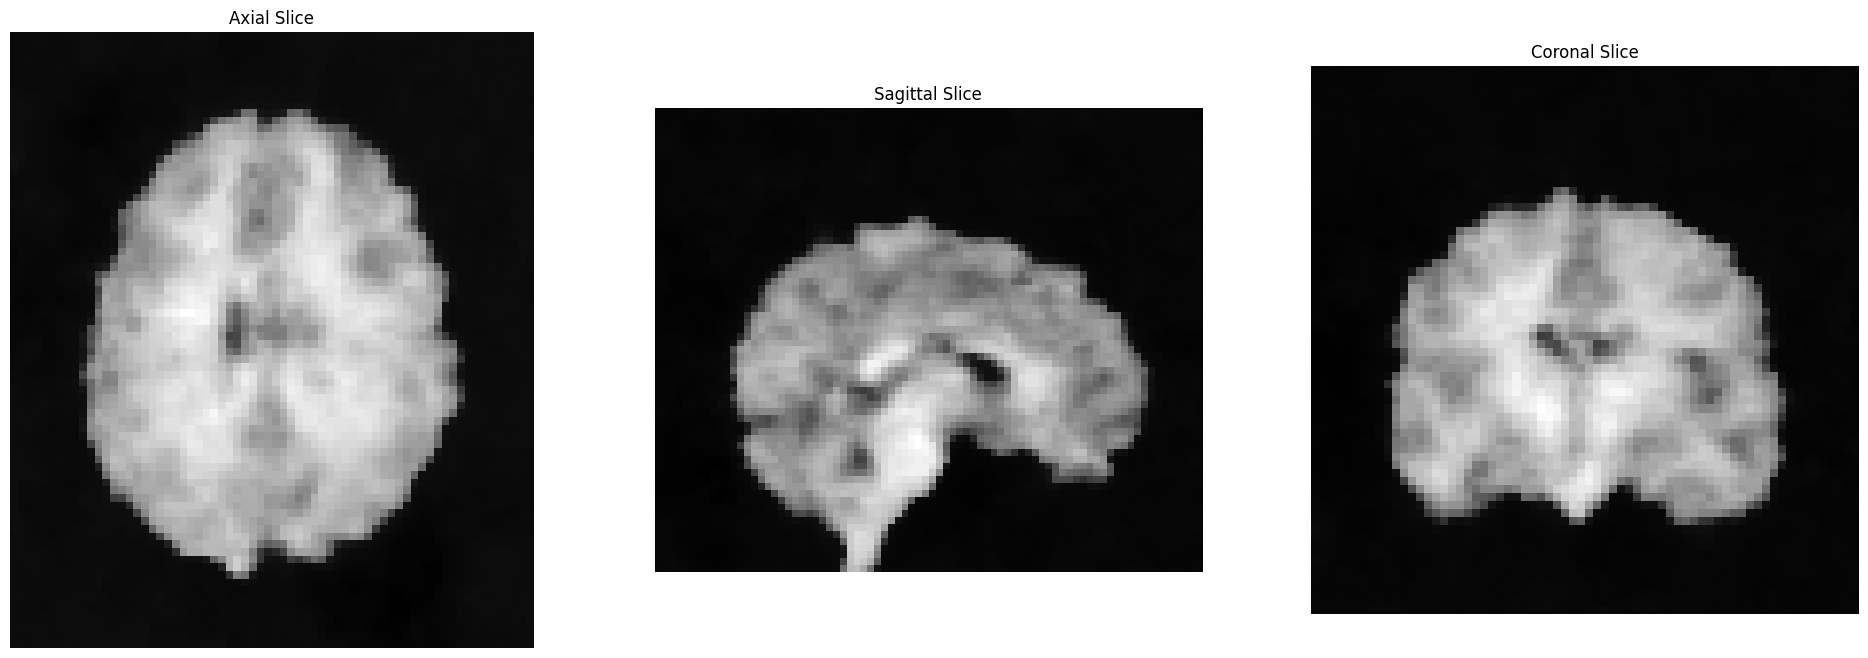

In [9]:
pred_mri.display_relevant_brain_slices()

15:06:52 | Reading data from ../../../hcp1200/996782/T1w_acpc_dc_restore_brain_downsample_factor_2.nii.gz
15:06:52 | Displaying relevant brain slices


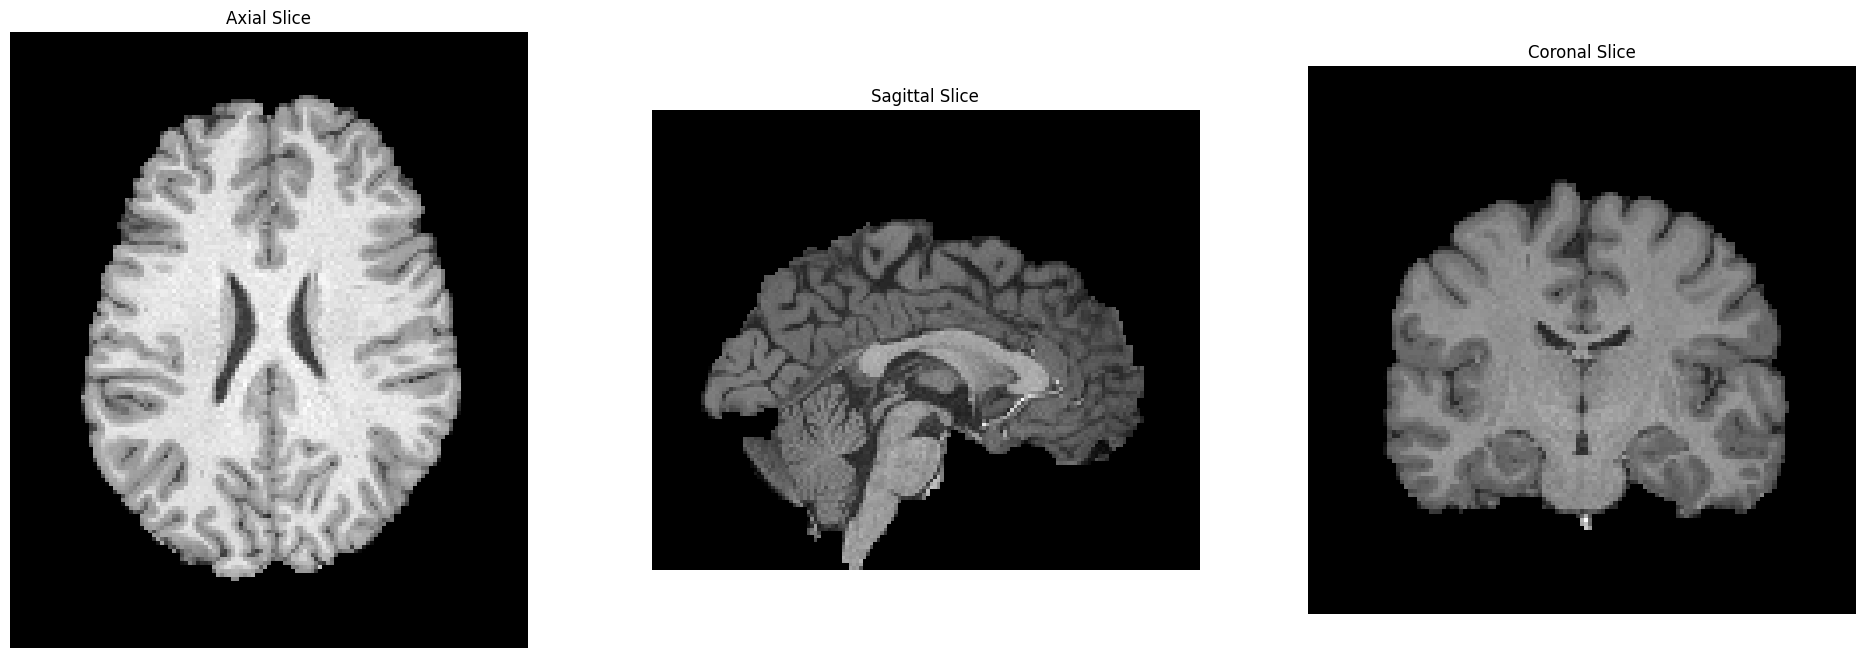

In [10]:
# Load the MRI data from the file
file_path = '../../../hcp1200/996782/T1w_acpc_dc_restore_brain_downsample_factor_2.nii.gz'
mri = MRI.from_nii_file(file_path)
mri.display_relevant_brain_slices()